In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import optuna
import tqdm
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from dataplotlib import make_heatmap
from lightgbm import LGBMClassifier

In [2]:
path = r'E:\Downloads\playground-series-s4e8'

In [3]:
train = pd.read_csv(path + r'\train.csv')

### EDA & Cleaning

In [4]:
train = train.drop(axis=1, columns=['id'])

In [5]:
train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,e,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,p,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,e,9.45,p,i,n,t,e,NaN,p,9.13,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


In [6]:
train.describe()

,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


In [7]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
non_cat_cols = train.columns.difference(cat_cols)

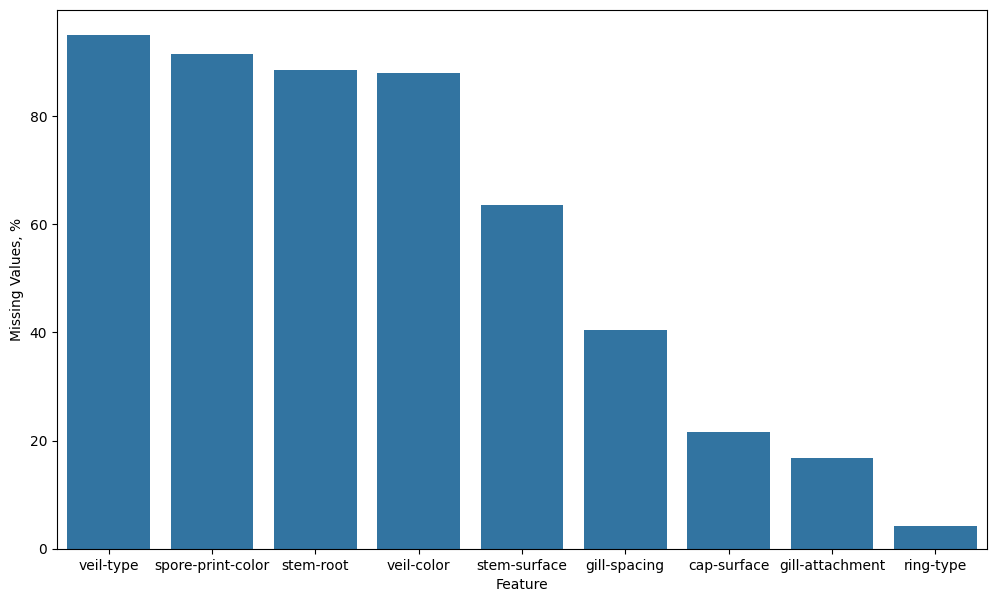

In [6]:
na_count = train.isna().sum()/len(train) * 100
na_count = na_count.sort_values(ascending=False)
na_count = na_count[na_count > 1]
fig = plt.figure(figsize=(12,7))
sns.barplot(x=na_count.index, y=na_count.values)
plt.xlabel('Feature')
plt.ylabel('Missing Values, %')
plt.show()

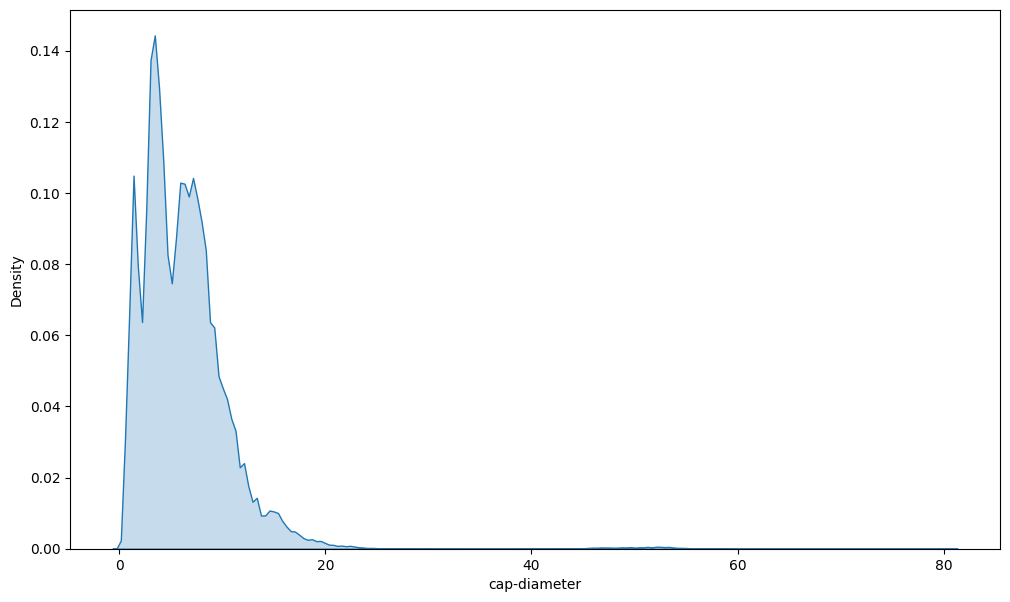

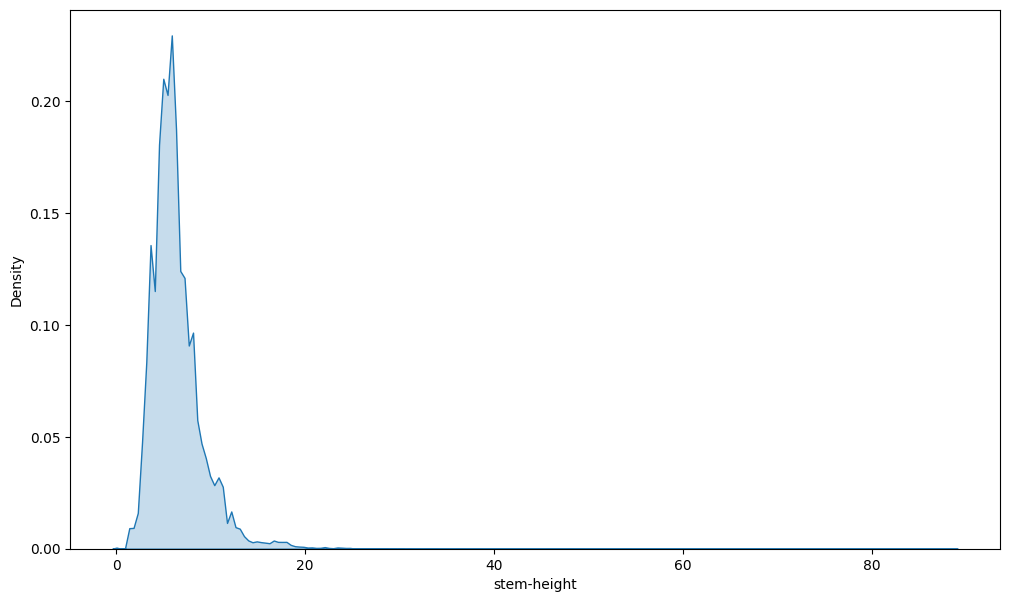

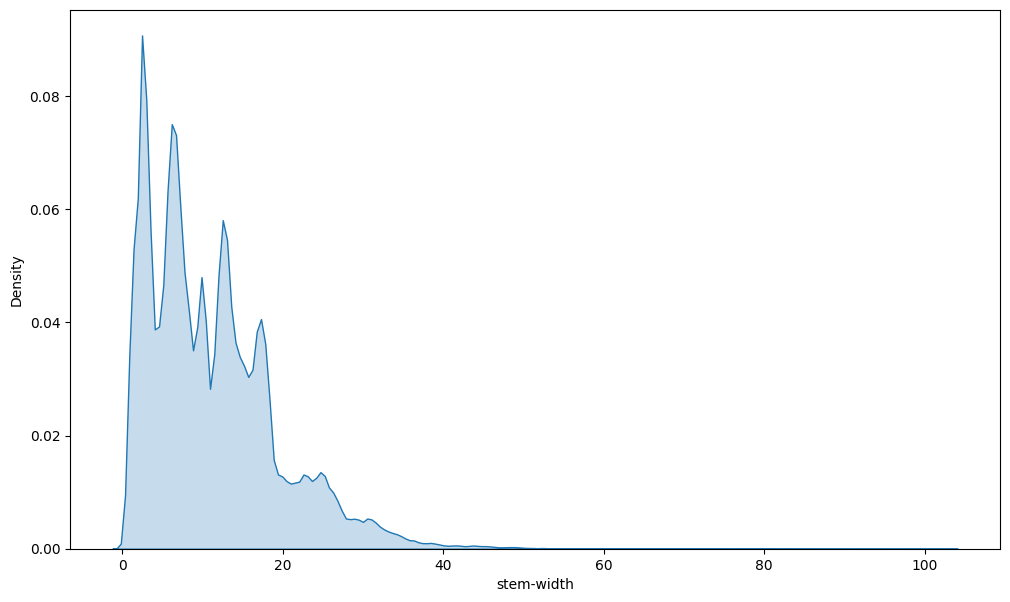

In [7]:
for col in non_cat_cols:
    fig = plt.figure(figsize=(12,7))
    sns.kdeplot(train[train[col].notna()][col], fill=True)
    plt.show()

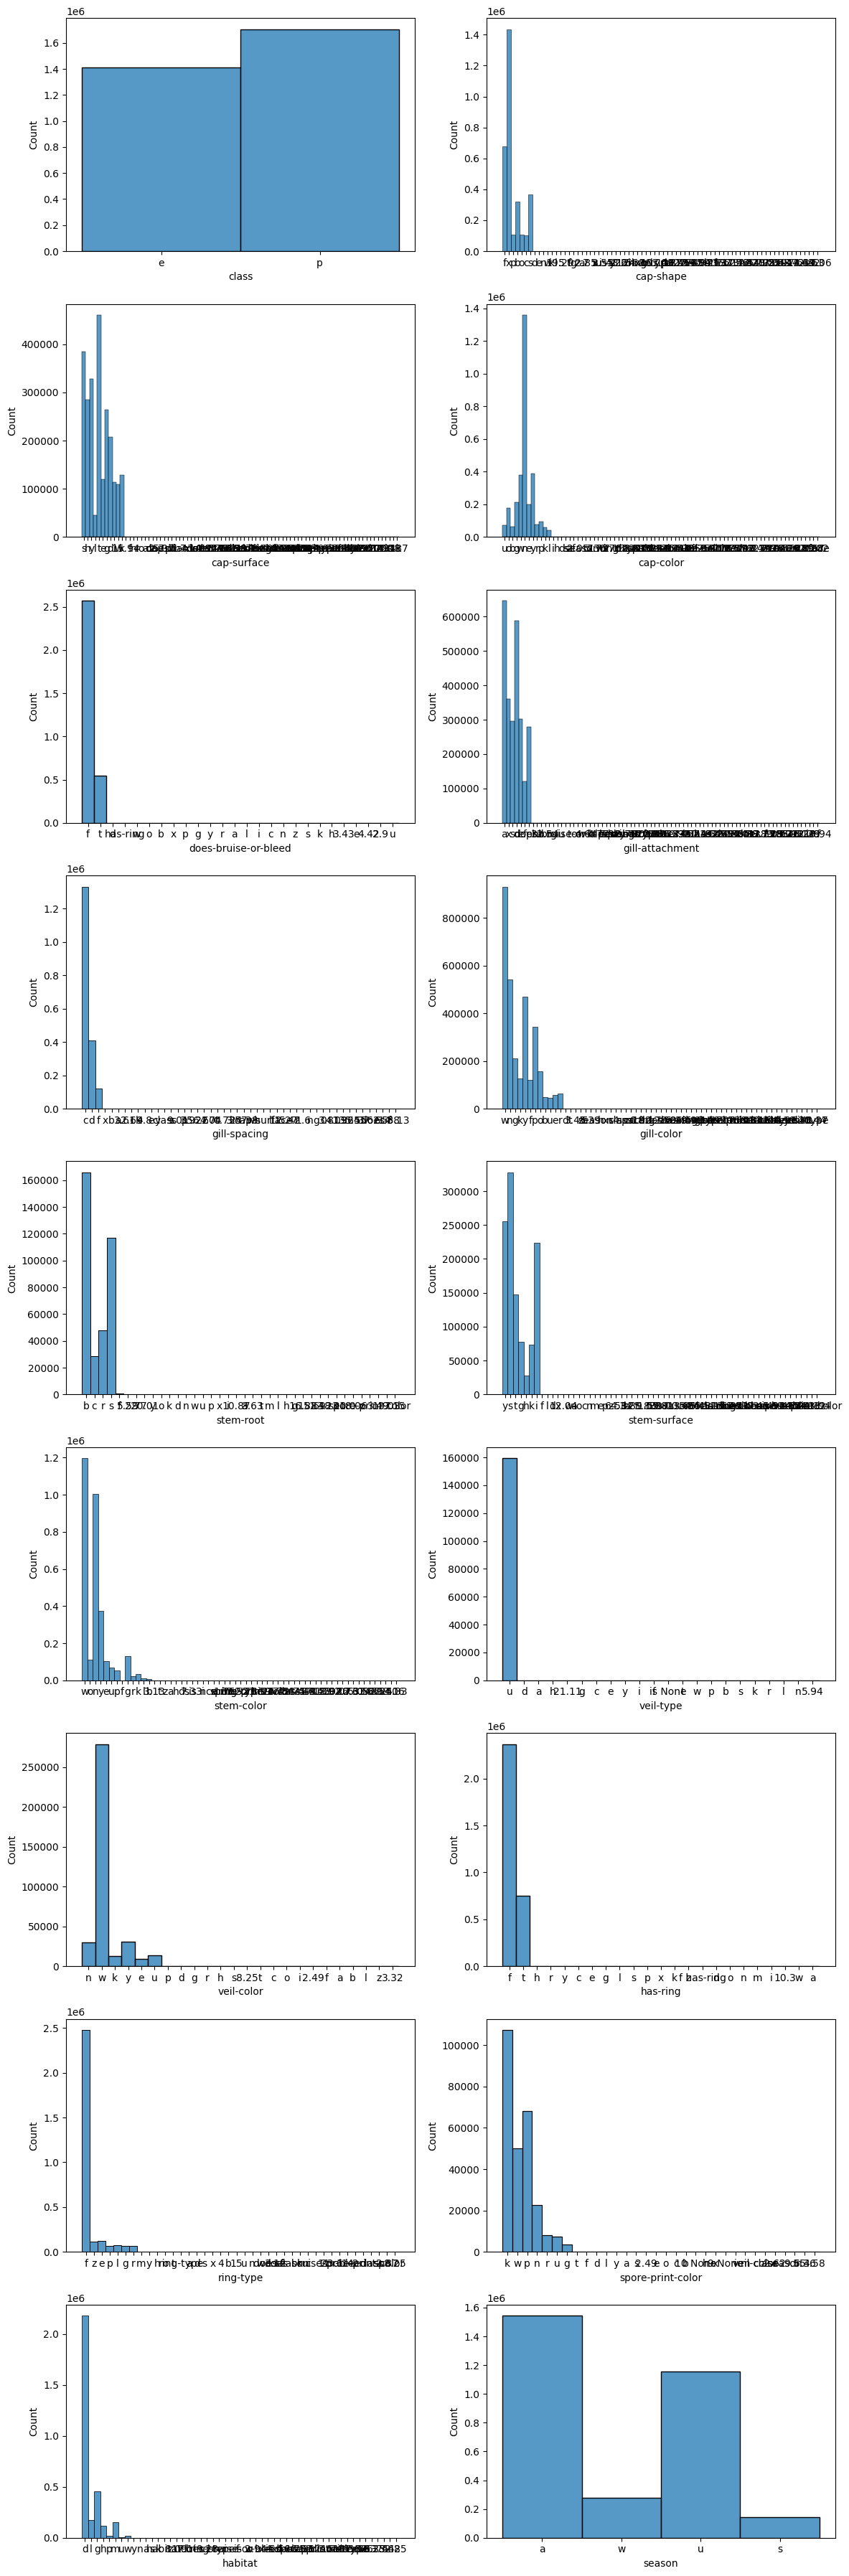

In [8]:
n_cols = len(cat_cols)
n_rows = (n_cols + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))


if n_rows > 1:
    axes = axes.flatten()

for i, column in enumerate(cat_cols):
    sns.histplot(train[train[column].notna()][column], ax=axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

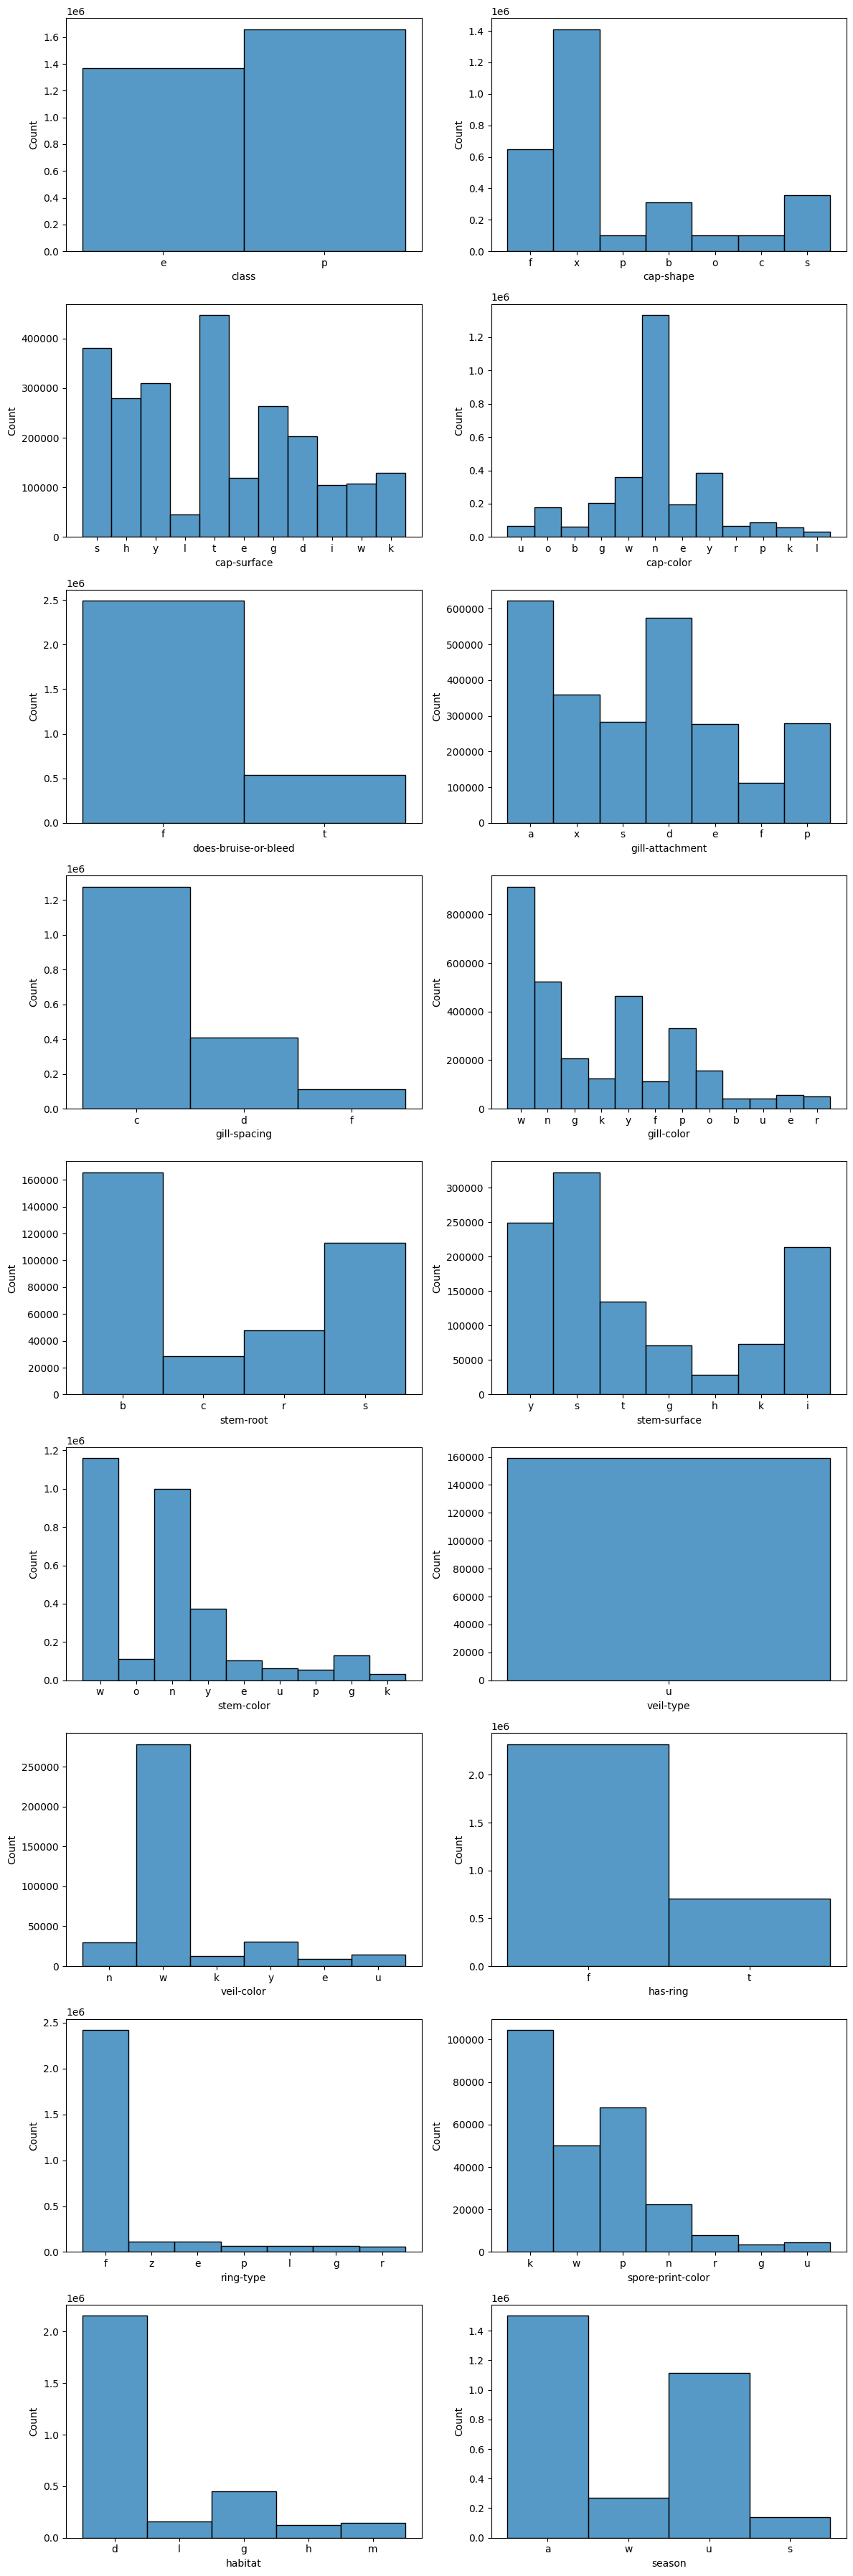

In [8]:
for column in cat_cols[1:]:
    value_counts = train[column].value_counts(normalize=True)
    mask = train[column].isin(value_counts[value_counts < 0.01].index)
    train = train[~mask]


n_cols = len(cat_cols)
n_rows = (n_cols + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))


if n_rows > 1:
    axes = axes.flatten()

for i, column in enumerate(cat_cols):
    sns.histplot(train[train[column].notna()][column], ax=axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [9]:
df_copy = train.copy()
for col in cat_cols:
    dummies = pd.get_dummies(df_copy[col], prefix=col)
    df_copy = pd.concat([df_copy, dummies], axis=1)
    df_copy.drop(col, axis=1, inplace=True)
corr = df_copy.corr()

new_df = pd.DataFrame(columns=cat_cols[1:])
res = []
corr.loc['class_p'] = corr.loc['class_p'].apply(abs)
for col in cat_cols[1:]:
    mean_value = corr.loc['class_p'].filter(like=col).mean()
    res.append(mean_value)
new_df.loc[0] = res

    #new_df[col] = corr
    #print(corr[['class_e']].loc[col])
df1 = corr[non_cat_cols].loc['class_p'].to_frame().transpose().reset_index(drop=True)
df1['class'] = 1
df = pd.concat([new_df, df1], axis=1)
df1
df = df.set_index('class')
df#.loc['class'].sort_values(axis=1)
fig = plt.figure(figsize=(15,7))
sns.heatmap(df, annot=True, cmap='coolwarm')
plt.title('Feature Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

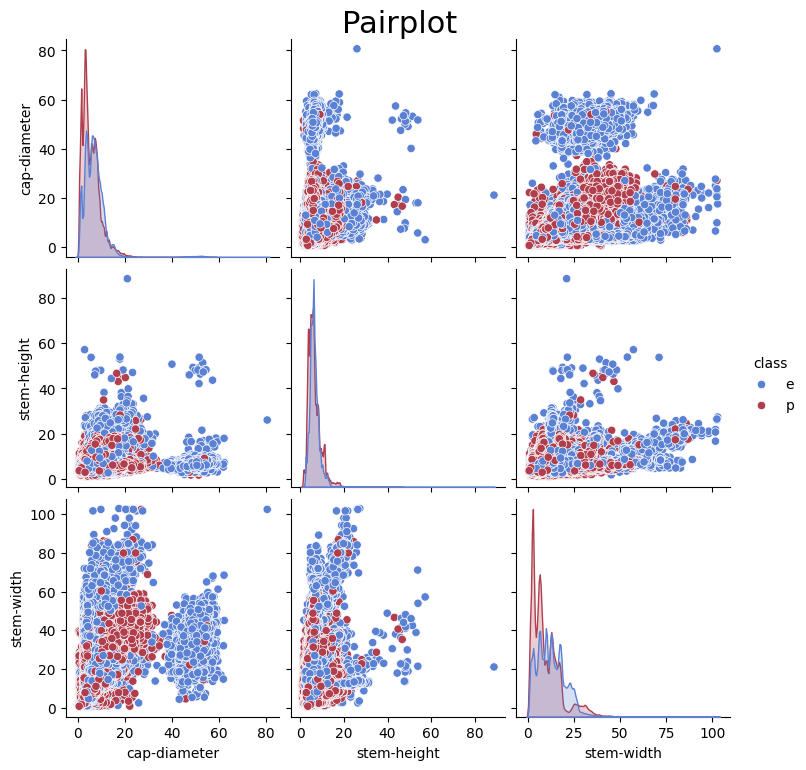

In [143]:
custom_palette = sns.color_palette(["#5b81d4", "#b03e4d"])
pairplot = sns.pairplot(train, hue='class', palette=custom_palette)
pairplot.figure.suptitle('Pairplot', fontsize=22, y=1.02)
plt.show()

# ML

In [150]:
X = train.drop(axis=1, columns='class')
for col in cat_cols[1:]:
    X[col] = X[col].fillna('NA')
for col in non_cat_cols:
    X[col] = X[col].fillna(np.median(X[col].values))
le = LabelEncoder()
y = train['class']
y = le.fit_transform(y)

## CBC

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols[1:])

val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols[1:])

In [ ]:
model.fit(train_pool)

## LGBM

In [153]:
lgbm_params = {'boosting_type': 'dart', 'learning_rate': 0.305,
               'n_estimators': 140, 'colsample_bytree': 0.63,
               'reg_lambda': 64.8, 'min_child_samples': 26, 
               'num_leaves': 235, 'verbose': -1}

model = LGBMClassifier(**lgbm_params)
X_encoded = pd.get_dummies(X)

In [154]:
model.fit(X_encoded, y)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.63, learning_rate=0.305,
               min_child_samples=26, n_estimators=140, num_leaves=235,
               reg_lambda=64.8, verbose=-1)

In [156]:
X_pred_encoded = pd.get_dummies(X_pred)

In [ ]:
subm = model.predict(X_pred_encoded)

## Optuna for CBC

In [ ]:
def objective(trial):
    iterations = trial.suggest_int('iterations', 200, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('depth', 2, 5)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-5, 1e-1, log=True)
    model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, early_stopping_rounds=50, od_type='IncToDec')
    model.fit(train_pool)
    score = model.eval_metrics(val_pool, metrics='MCC')[0]
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial.params)
print('Best validation score:', study.best_value)

## Prediction data

In [155]:
X_pred = pd.read_csv(path + r'\test.csv')
ids = X_pred['id']
X_pred = X_pred.drop(axis=1, columns='id')
for cc in cat_cols[1:]:
    X_pred[cc] = X_pred[cc].astype(str)
    X_pred[cc] = X_pred[cc].fillna('NA')


for ncc in non_cat_cols:
    X_pred[ncc] = X_pred[ncc].astype(np.float64)
    X_pred[ncc] = X_pred[ncc].fillna(np.median(X_pred[ncc].values))

### Submission

In [77]:
subm = model.predict(X_pred)
subm = le.inverse_transform(subm)
submission_sample = pd.read_csv(path + r'\sample_submission.csv')
submission_sample['class'] = subm
submission_sample.to_csv(r'C:\Users\h\Desktop\ans.csv', index=False)